In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import linalg

def get_J_kl(k: int, l: int)-> float:
    if 2 * l - k == 0:
        return 1.
    else:
        if k % 2 == 0:
            return 0.
        elif (2 * l - k ) % 4 == 1:
            return 1 / (np.pi * (l - k/2))
        else:
            return -1 / (np.pi * (l - k/2))

# Linear stability analysis for kinetic equation of voro VM

For the two-species case, the Boltzmann equation for the Fourier modes $f_k(\mathbf{r},t)$ reads
$$
\partial_t f_k + \frac{1}{2} (\nabla f_{k-1}+\nabla^* f_{k+1}) = (P_k -1 -\alpha)f_k + \frac{\alpha}{\rho_A +\rho_B} P_k \sum_{l=-\infty}^\infty J_{kl} f_{k-l} (f_{l} + \delta_{0,l}\rho_B),
$$
where the complex operators $\nabla = \partial_x + i\partial_y$ and $\nabla^* = \partial_x - i\partial_y$ have been used, $P_k=\int_{-\infty}^\infty d\eta P_\sigma (\eta) e^{ik\eta} = e^{-k^2 \sigma^2/2}$ are the modes of the noise distribution with zeor mean and  variance $\sigma^2$.
$J_{kl}$ is an integral depending on the alignment rule, which read
$$
J_{kl}=\frac{1}{2\pi}\int_{-\pi}^\pi d\theta \cos[(l-k/2)\theta].
$$

## Homogeneous solution
The homogeneous solution $\mathcal{F}=\{\bar{f}_k\}_{k\geq 0}$ satisfy
$$
(P_k-1-\alpha) \bar{f}_k + \frac{\alpha}{\rho_{A,0} +\rho_B} P_k \sum_{l=-\infty}^{\infty} J_{kl} \bar{f}_{k-l} (\bar{f}_{l} +\delta_{0,l}\rho_B), \quad \mathrm{for\ any\ } k\geq 0.
$$
For $k=0$, we have $P_0=1$, $J_{0l} = \delta_{0,l}$, such that $\bar{f}_0=\bar{\rho}_{A}$. Setting all $\bar{f}_k$ with $|k|>K$ to zero, we get
$$
(P_k-1-\alpha) \bar{f}_k + \frac{\alpha}{\bar{\rho}_A+\rho_B} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^{K} J_{kl} \bar{f}_{k-l} (\bar{f}_{l}+ \delta_{0,l}\rho_B), \quad \mathrm{for\ any\ } k\geq 1.
$$

[9.50000000e-01 8.93550487e-01 7.67426390e-01 6.31691448e-01
 5.04848553e-01 3.87448566e-01 2.86161896e-01 2.06232212e-01
 1.45287877e-01 9.91207874e-02 6.53406511e-02 4.19214324e-02
 2.63403504e-02 1.62340853e-02 9.82503696e-03 5.84377043e-03
 3.40830208e-03 1.94165772e-03 1.07892989e-03 5.85292158e-04
 3.09868329e-04]


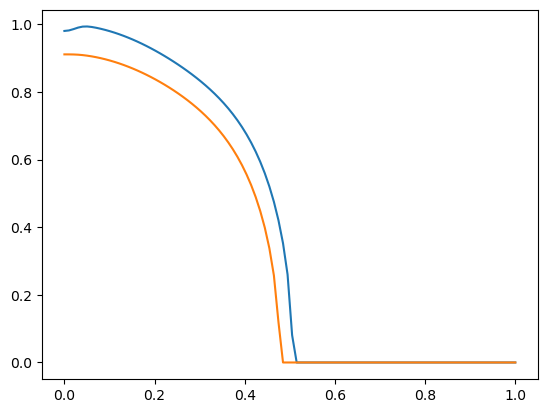

In [2]:
def get_P_k(k: int, eta: float)-> float:
    return np.exp(-0.5 * (k * eta)**2)

def func_HS(x, rhoA, rhoB, eta, alpha):
    K = x.size - 1
    y = np.zeros(K+1)
    rho0 = rhoA + rhoB
    for k in range(0, y.size):
        P_k = get_P_k(k, eta)
        y[k] = (P_k - 1 - alpha) * x[k]
        S = 0.
        for l in range(-K, K+1):
            m = abs(k - l)
            if m <= K:
                S += get_J_kl(k, l) * x[abs(l)] * x[m]
        y[k] += alpha / rho0 * P_k * (S + get_J_kl(k, 0) * x[k] * rhoB)
    return y

def get_f_bar(K, eta, rhoA, rhoB, alpha):
    x0 = np.zeros(K+1)
    x0[0] = rhoA
    for i in range(1, K+1):
        x0[i] = 0.8 ** i
    f_bar = fsolve(func_HS, x0, args=(rhoA, rhoB, eta, alpha))
    return f_bar

rho0 = 1
rhoB = 0.
rhoA = rho0 - rhoB
alpha = 1
K = 20


eta_arr = np.linspace(0, 1, 100)
fk = np.array([get_f_bar(K, eta, rhoA, rhoB, alpha) for eta in eta_arr])
plt.plot(eta_arr, fk[:, 1])
# plt.plot(eta_arr, fk[:, 2])


rhoB = 0.05
rhoA = rho0 - rhoB
print(get_f_bar(K, 0.1, rhoA, rhoB, alpha))

eta_arr = np.linspace(0, 1, 100)

fk = np.array([get_f_bar(K, eta, rhoA, rhoB, alpha) for eta in eta_arr])
plt.plot(eta_arr, fk[:, 1])
# plt.plot(eta_arr, fk[:, 2])
# plt.plot(eta_arr, fk[:, 3])
# plt.plot(eta_arr, fk[:, 4])
# plt.plot(eta_arr, fk[:, 5])
plt.show()
plt.close()

## Linear stability analysis
Linearizing the modes as $f_k = \bar{f}_k + \delta f_k$, we get
$$
\begin{aligned}
\partial_t \delta f_k + \frac{1}{2}(\nabla^* \delta f_{k+1} +\nabla \delta f_{k-1}) &= (P_k-1-\alpha)
\delta f_k 
+ \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K [(J_{k, l}+ J_{k, k-l}) \bar{f}_{k-l} + J_{k, k-l}\delta_{0, k-l}\rho_B ]\delta f_l
-\frac{\alpha \delta \rho}{\rho_0^2} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K J_{k, l}\bar{f}_{k-l}(\bar{f}_{l}+\delta_{0,l}\rho_B) \\
&= (P_k-1-\alpha) (\delta f_k + \frac{\bar{f}_k}{\rho_0} \delta \rho) 
+ \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l}) \bar{f}_{k-l} \delta f_l
+ \frac{\alpha}{\rho_0} P_k J_{k, 0} \rho_B \delta f_k
\end{aligned}
$$

In [3]:
def get_M_cross_base(K: int):
    M_gg_base = np.zeros((K+1, K+1), complex)
    M_gh_base = np.zeros((K+1, K+1), complex)
    M_hg_base = np.zeros((K+1, K+1), complex)
    M_hh_base = np.zeros((K+1, K+1), complex)

    # k=0 row
    M_gg_base[0, 1] = 2
    M_gh_base[0, 1] = 2
    # M_hg_q[0, 1] = 0.
    # M_hh_q[0, 1] = 0.

    # k=1, 2, ..., K-1
    for k in range(1, K):
        M_gg_base[k, k+1] = 1
        M_gg_base[k, k-1] = 1
        M_gh_base[k, k+1] = 1
        M_gh_base[k, k-1] = -1

        M_hg_base[k, k+1] = -1
        M_hg_base[k, k-1] = 1
        M_hh_base[k, k+1] = 1
        M_hh_base[k, k-1] = 1

    # k=K
    M_gg_base[K, K-1] = 1
    M_gh_base[K, K-1] = -1
    M_hg_base[K, K-1] = 1
    M_hh_base[K, K-1] = 1
    return M_gg_base, M_gh_base, M_hg_base, M_hh_base


def get_M_q(qx, qy, M_gg_base, M_gh_base, M_hg_base, M_hh_base):
    M_gg_q = -0.5j * qx * M_gg_base
    M_gh_q = -0.5j * qy * M_gh_base
    M_hg_q = -0.5j * qy * M_hg_base
    M_hh_q = -0.5j * qx * M_hh_base
    return M_gg_q, M_gh_q, M_hg_q, M_hh_q


def get_M_0(eta, rhoA, rhoB, alpha, K):
    rho0 = rhoA + rhoB
    f_bar = get_f_bar(K, eta, rhoA, rhoB, alpha)
    Pk = np.array([get_P_k(k, eta) for k in range(K+1)])

    diag_arr = Pk - 1 - alpha
    M_gg_0 = np.diag(diag_arr)
    M_gg_0[:, 0] += diag_arr * f_bar / rho0

    M_hh_0 = np.copy(M_gg_0)

    for k in range(0, K+1):
        tmp = alpha / rho0 * Pk[k]
        # j = 0 column
        M_k0 = tmp * (get_J_kl(k, 0) + get_J_kl(k, k)) * f_bar[k]
        M_gg_0[k, 0] += M_k0
        M_hh_0[k, 0] += M_k0
        for j in range(1, K+1):
            m1 = abs(k-j)
            sum1 = (get_J_kl(k, j) + get_J_kl(k, k-j)) * f_bar[m1]

            l = -j
            m2 = abs(k-l)
            if m2 <= K:
                sum2 = (get_J_kl(k, l) + get_J_kl(k, k-l)) * f_bar[m2]
            else:
                sum2 = 0
            
            M_gg_0[k, j] += tmp * (sum1 + sum2)
            M_hh_0[k, j] += tmp * (sum1 - sum2)
        M_gg_0[k, k] += tmp * get_J_kl(k, 0) * rhoB
        M_hh_0[k, k] += tmp * get_J_kl(k, 0) * rhoB
    return M_gg_0, M_hh_0, f_bar


def assemble_matrix(M_gg_0, M_hh_0, M_gg_base, M_gh_base, M_hg_base, M_hh_base, qx, qy):
    M_gg_q, M_gh_q, M_hg_q, M_hh_q = get_M_q(qx, qy, M_gg_base, M_gh_base, M_hg_base, M_hh_base)
    n = M_gg_0.shape[0]
    M = np.zeros((2 * n, 2 * n), complex)
    M[:n, :n] = M_gg_0 + M_gg_q
    M[:n, n:] = M_gh_q
    M[n:, :n] = M_hg_q
    M[n:, n:] = M_hh_0 + M_hh_q
    return M

def get_M(eta, rhoA, rhoB, alpha, K, qx, qy):
    M_gg_0, M_hh_0, f_bar = get_M_0(eta, rhoA, rhoB, alpha, K)
    M_gg_base, M_gh_base, M_hg_base, M_hh_base = get_M_cross_base(K)
    M = assemble_matrix(M_gg_0, M_hh_0, M_gg_base, M_gh_base, M_hg_base, M_hh_base, qx, qy)
    return M, f_bar

8.109426928112708e-09 -2.491062911502695e-14
0.00016477004564192715 1.249000902703301e-16
0.0002632623360611123 -5.551115123125783e-17
0.0003131462646851198 -2.220446049250313e-16
0.00036169937005394196 -1.942890293094024e-16
0.0004080187290540592 -1.3877787807814457e-16


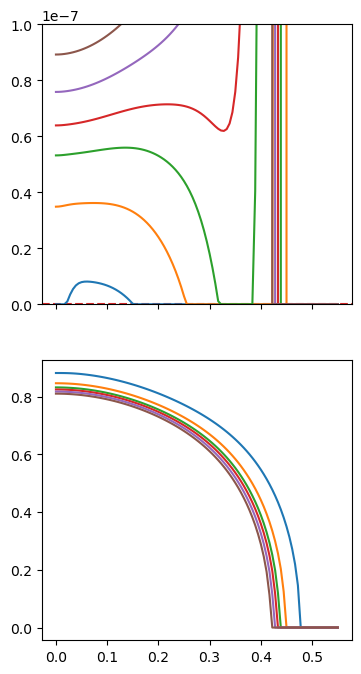

In [129]:
rho0 = 1
rhoB = 0.08
rhoA = rho0-rhoB
alpha = 1
qx = 1e-3
qy = 0

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(4, 8))
ax1.axhline(0, linestyle="dashed", c="tab:red")

K = 20
eta_arr = np.linspace(0, 0.55, 100)
sigma = np.zeros_like(eta_arr)
f1_arr = np.zeros_like(eta_arr)

for rhoB in [0.05, 0.1, 0.12, 0.13, 0.14, 0.15]:
    for i, eta in enumerate(eta_arr):
        M, f_bar = get_M(eta, rhoA, rhoB, alpha, K, qx, qy)
        sigma_re = linalg.eigvals(M).real
        sigma[i] = np.max(sigma_re)
        f1_arr[i] = f_bar[1]
    ax1.plot(eta_arr, sigma, "-")
    ax2.plot(eta_arr, f1_arr, "-")
    print(sigma.max(),sigma.min())

# K = 100
# for i, eta in enumerate(eta_arr):
#     M, f_bar = get_M(eta, rhoA, rhoB, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
#     f1_arr[i] = f_bar[1]
# ax1.plot(eta_arr, sigma, "-")
# ax2.plot(eta_arr, f1_arr, "-")
# print(sigma.max(),sigma.min())

# K = 20
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rhoA, rhoB, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "-s")


# K = 50
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rhoA, rhoB, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "->")

# K = 100
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rhoA, rhoB, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "->")

ax1.set_ylim(0, 1e-7)
plt.show()
plt.close()